In [35]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [36]:
from matplotlib import rcParams, pyplot as plt

import numpy as np
import pandas as pd
import random as rn
import re
from collections import Counter


from pathlib import Path
import warnings

from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk import pos_tag

from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Bidirectional, GlobalMaxPool1D, Dropout, SpatialDropout1D, GRU, SimpleRNN

from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.utils import to_categorical

from gensim.models import Word2Vec

In [37]:
rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

## 학습데이터 로드

In [44]:
data_dir = Path('../data/dacon-novel-author-classification')
feature_dir = Path('../build/feature')
val_dir = Path('../build/val')
tst_dir = Path('../build/tst')
sub_dir = Path('../build/sub')

trn_file = data_dir / 'train.csv'
tst_file = data_dir / 'test_x.csv'
sample_file = data_dir / 'sample_submission.csv'

target_col = 'author'
n_fold = 5
n_class = 5
seed = 2020

np.random.seed(seed)
rn.seed(seed)
tf.random.set_seed(seed)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [39]:
algo_name = 'eda'
feature_name = 'data'
model_name = f'{algo_name}_{feature_name}'

feature_file = feature_dir / f'{feature_name}.csv'

p_val_file = val_dir / f'{model_name}.val.csv'
p_tst_file = tst_dir / f'{model_name}.tst.csv'

sub_file = sub_dir / f'{model_name}.csv'

In [6]:
trn = pd.read_csv(trn_file, index_col=0)
print(trn.shape)
trn.head()

(54879, 2)


,text,author
index,,
0,"He was almost choking. There was so much, so m...",3
1,"“Your sister asked for it, I suppose?”",2
2,"She was engaged one day as she walked, in per...",1
3,"The captain was in the porch, keeping himself ...",4
4,"“Have mercy, gentlemen!” odin flung up his han...",3


In [7]:
tst = pd.read_csv(tst_file, index_col=0)
print(tst.shape)
tst.head()

(19617, 1)


,text
index,
0,“Not at all. I think she is one of the most ch...
1,"""No,"" replied he, with sudden consciousness, ""..."
2,As the lady had stated her intention of scream...
3,“And then suddenly in the silence I heard a so...
4,His conviction remained unchanged. So far as I...


# 데이터 전처리

In [8]:
#부호를 제거해주는 함수
def alpha_num(text):
    return re.sub(r"[^A-Za-z0-9' ]", '', text)

In [9]:
#전처리 적용
trn['text'] = trn['text'].str.lower()
tst['text'] = tst['text'].str.lower()

trn['text'] = trn['text'].apply(alpha_num)
tst['text'] = tst['text'].apply(alpha_num)

In [10]:
# train test 분리
X_train = trn['text'].values
X_test = tst['text'].values
y_train = trn['author'].values
print(X_train.shape, X_test.shape, y_train.shape)

(54879,) (19617,) (54879,)


In [11]:
X_train

array(['he was almost choking there was so much so much he wanted to say but strange exclamations were all that came from his lips the pole gazed fixedly at him at the bundle of notes in his hand looked at odin and was in evident perplexity',
       'your sister asked for it i suppose',
       ' she was engaged one day as she walked in perusing janes last letter and dwelling on some passages which proved that jane had not written in spirits when instead of being again surprised by mr odin she saw on looking up that odin was meeting her putting away the letter immediately and forcing a smile she said',
       ..., ' your sincere wellwisher friend and sister lucy odin',
       'then you wanted me to lend you money',
       'it certainly had not occurred to me before but i said yes i should like that'],
      dtype=object)

## 시각화 

In [12]:
def get_info(data):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(data)
    sequences = tokenizer.texts_to_sequences(data)
    word_to_index = tokenizer.word_index
    
    
    threshold = 2
    total_cnt = len(word_to_index) # 단어의 수
    rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카우늩
    total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총합
    rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합
    
    for key, value in tokenizer.word_counts.items():
        total_freq = total_freq + value
        
        if value < threshold :
            rare_cnt = rare_cnt + 1
            rare_freq = rare_freq + value
            
    print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
    print("단어 집합(vocabulary)에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
    print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)
    print('텍스트의 최대 길이 : %d' % max(len(l) for l in sequences))
    print('텍스트의 평균 길이 : %d' % (sum(map(len,sequences))/len(sequences)))
    # 단어 집합의 크기 설정
    vocab_size = len(word_to_index) + 1
    print('단어 집합의 크기: {}'.format((vocab_size)))
    plt.hist([len(s) for s in sequences], bins=50)
    plt.xlabel('length of samples')
    plt.ylabel('number of samples')
    plt.show()

등장 빈도가 1번 이하인 희귀 단어의 수: 23251
단어 집합(vocabulary)에서 희귀 단어의 비율: 46.62883041873897
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.0053890861384644
텍스트의 최대 길이 : 471
텍스트의 평균 길이 : 42
단어 집합의 크기: 49865


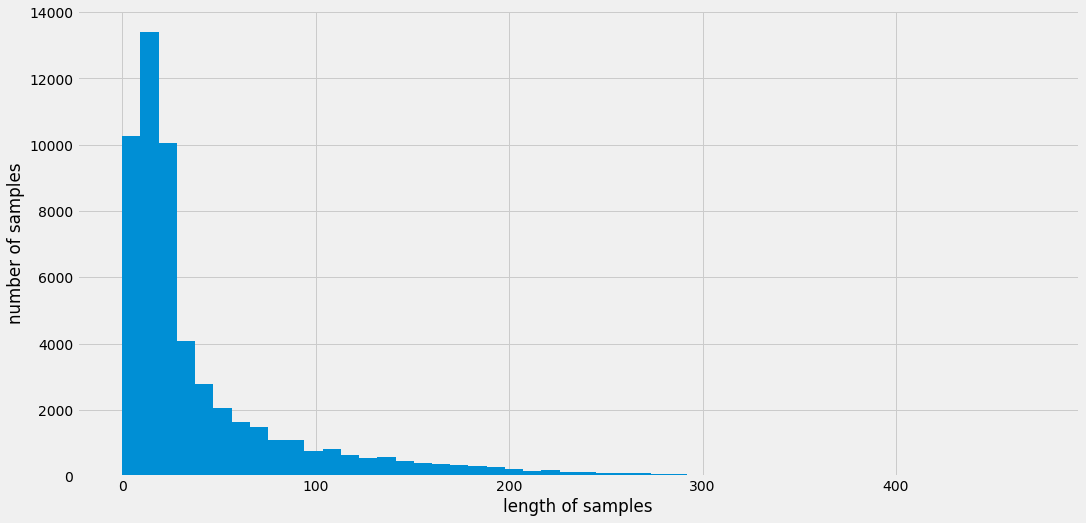

In [13]:
get_info(X_train)

In [14]:
author_data = []

for i in range(len(trn['author'].unique())):
    temp = trn[trn['author']==i]['text']
    author_data.append(temp)

In [15]:
len(author_data)

5

등장 빈도가 1번 이하인 희귀 단어의 수: 10256
단어 집합(vocabulary)에서 희귀 단어의 비율: 46.34014097234773
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.071827110714271
텍스트의 최대 길이 : 371
텍스트의 평균 길이 : 37
단어 집합의 크기: 22133


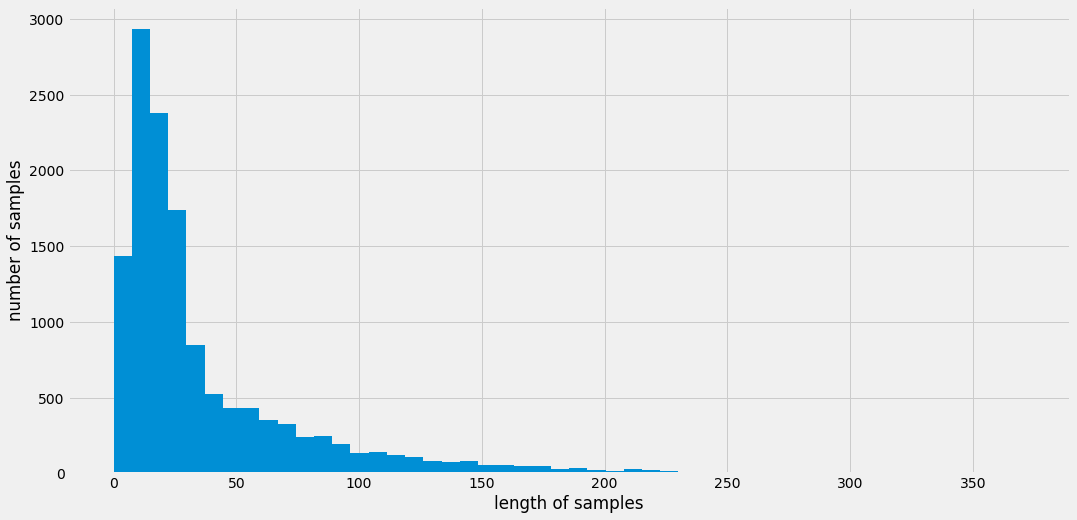

In [16]:
get_info(author_data[0])

등장 빈도가 1번 이하인 희귀 단어의 수: 7520
단어 집합(vocabulary)에서 희귀 단어의 비율: 47.8584611468211
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.8229816901852314
텍스트의 최대 길이 : 426
텍스트의 평균 길이 : 57
단어 집합의 크기: 15714


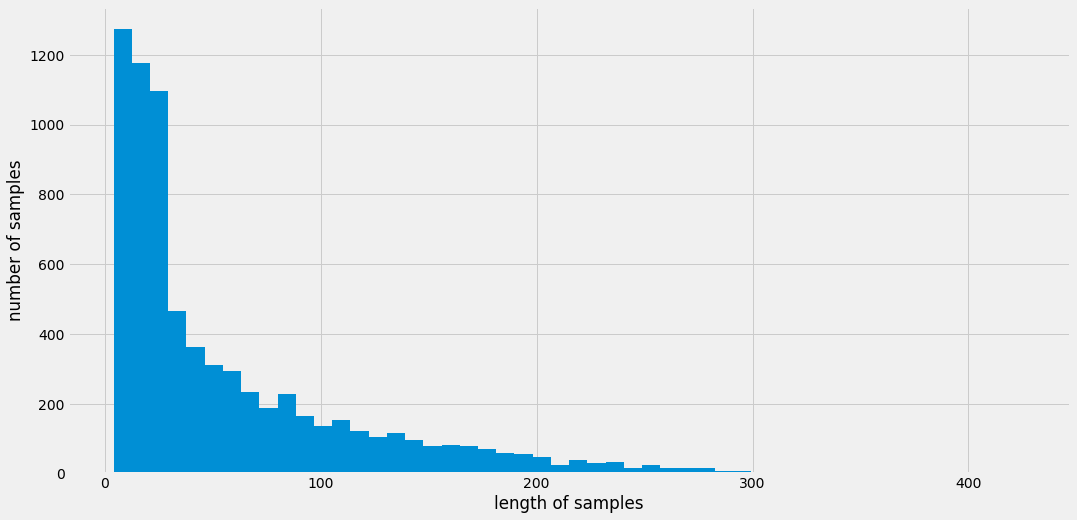

In [17]:
get_info(author_data[1])

등장 빈도가 1번 이하인 희귀 단어의 수: 9545
단어 집합(vocabulary)에서 희귀 단어의 비율: 44.53620754012692
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.0609141001502773
텍스트의 최대 길이 : 302
텍스트의 평균 길이 : 40
단어 집합의 크기: 21433


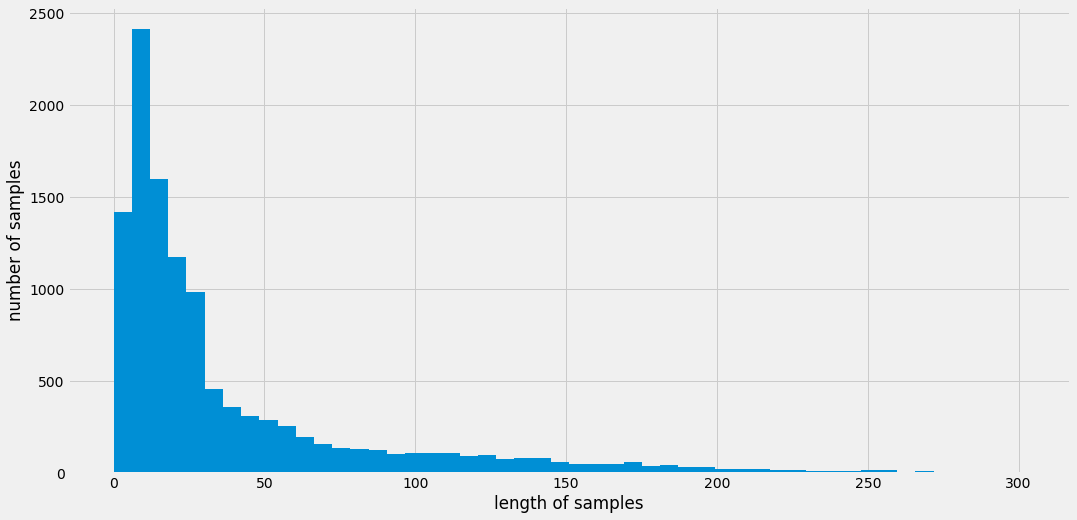

In [18]:
get_info(author_data[2])

등장 빈도가 1번 이하인 희귀 단어의 수: 8484
단어 집합(vocabulary)에서 희귀 단어의 비율: 43.25261279632934
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.3737046632124352
텍스트의 최대 길이 : 471
텍스트의 평균 길이 : 41
단어 집합의 크기: 19616


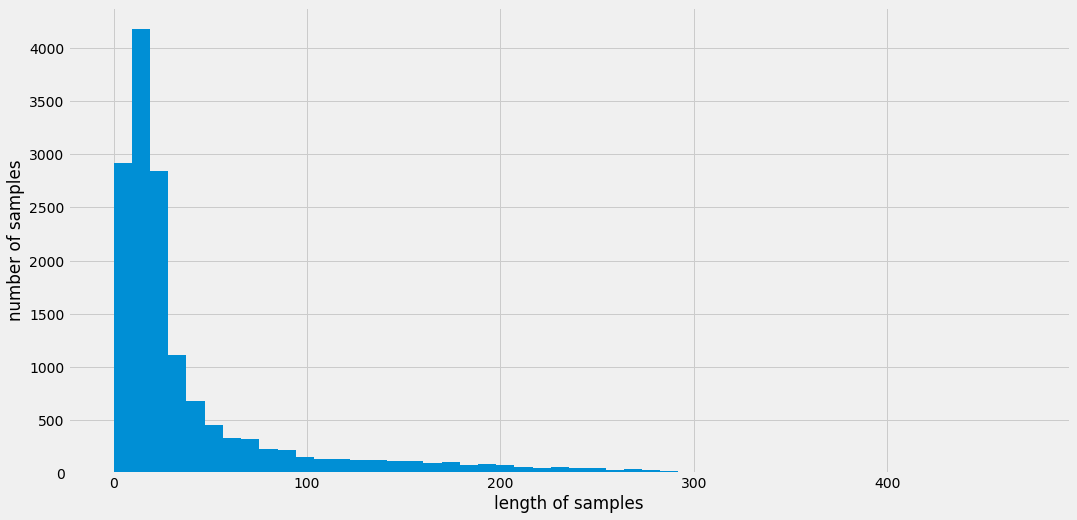

In [19]:
get_info(author_data[3])

등장 빈도가 1번 이하인 희귀 단어의 수: 8826
단어 집합(vocabulary)에서 희귀 단어의 비율: 47.316785503672335
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.7210506844247133
텍스트의 최대 길이 : 349
텍스트의 평균 길이 : 41
단어 집합의 크기: 18654


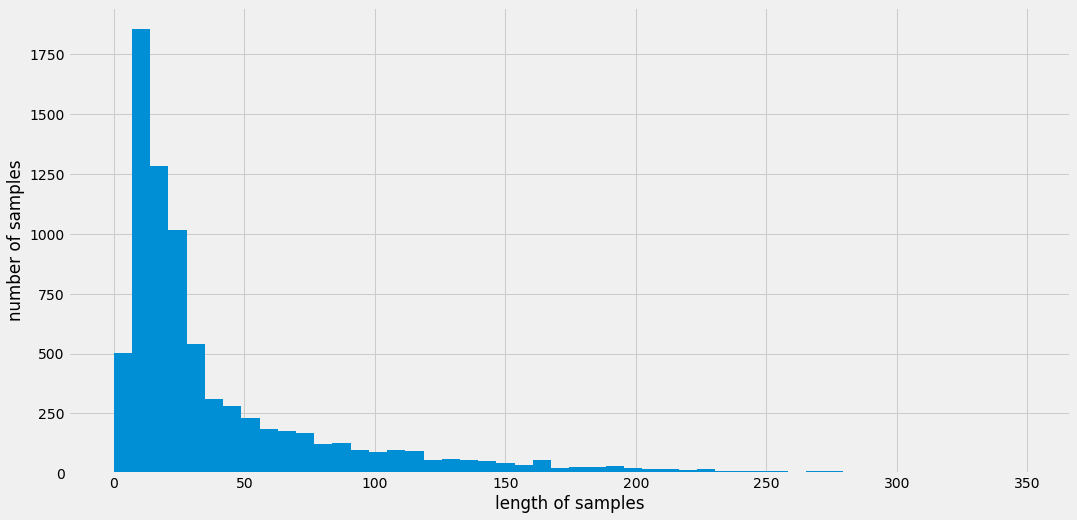

In [20]:
get_info(author_data[4])

## TOP 100 단어 분석 

In [21]:
def get_top_n_vocab(data, top=None):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(data)
    
    if top is None:
        vocab_size = len(tokenizer.word_index)
    else:
        vocab_size = min(top,len(tokenizer.word_index))
    
    vocab = {}
    for word, index in tokenizer.word_index.items(): 
        if index == vocab_size+1:
            break
        vocab[word] = (index, tokenizer.word_counts[word])
        
    return vocab

In [22]:
all_vocab = get_top_n_vocab(X_train)

In [23]:
print(all_vocab)

{'the': (1, 109417), 'and': (2, 72910), 'to': (3, 61273), 'of': (4, 57870), 'i': (5, 52962), 'a': (6, 50592), 'in': (7, 36378), 'odin': (8, 35910), 'he': (9, 34205), 'you': (10, 32731), 'was': (11, 32044), 'it': (12, 31681), 'that': (13, 31273), 'his': (14, 24515), 'with': (15, 20626), 'had': (16, 19537), 'for': (17, 18304), 'as': (18, 17847), 'at': (19, 17457), 'not': (20, 17424), 'her': (21, 17351), 'my': (22, 16793), 'but': (23, 16464), 'is': (24, 16231), 'have': (25, 15408), 'be': (26, 14802), 'she': (27, 14372), 'me': (28, 13924), 'him': (29, 13552), 'said': (30, 13443), 'on': (31, 12585), 'all': (32, 11087), 'so': (33, 10031), 'this': (34, 9844), 'from': (35, 8871), 'by': (36, 8846), 'what': (37, 8787), 'no': (38, 8539), 'were': (39, 8354), 'which': (40, 8342), 'there': (41, 8321), 'we': (42, 7641), 'one': (43, 7577), 'they': (44, 7350), 'if': (45, 7308), 'would': (46, 7297), 'been': (47, 7271), 'are': (48, 7141), 'your': (49, 6965), 'very': (50, 6703), 'an': (51, 6699), 'mr': (5

In [24]:
author_data = []

for i in range(len(trn['author'].unique())):
    temp = trn[trn['author']==i]['text']
    author_data.append(temp)

In [25]:
author_vocab = []

for i in range(len(trn['author'].unique())):
    temp = get_top_n_vocab(author_data[i],100)
    author_vocab.append(temp)

In [26]:
print(author_vocab[0])

{'the': (1, 22724), 'and': (2, 16336), 'i': (3, 13546), 'to': (4, 13263), 'of': (5, 11739), 'a': (6, 10902), 'in': (7, 8054), 'odin': (8, 7333), 'that': (9, 6761), 'was': (10, 6598), 'it': (11, 6534), 'he': (12, 6022), 'you': (13, 5911), 'his': (14, 5518), 'my': (15, 4985), 'said': (16, 4755), 'with': (17, 4706), 'as': (18, 4187), 'had': (19, 4120), 'me': (20, 3972), 'her': (21, 3854), 'at': (22, 3709), 'for': (23, 3396), 'mr': (24, 3166), 'on': (25, 3154), 'have': (26, 3042), 'him': (27, 2935), 'not': (28, 2781), 'be': (29, 2685), 'she': (30, 2564), 'is': (31, 2553), 'but': (32, 2537), 'so': (33, 2128), 'by': (34, 1995), 'this': (35, 1986), 'if': (36, 1962), 'all': (37, 1928), 'when': (38, 1887), 'were': (39, 1845), 'no': (40, 1715), 'what': (41, 1675), 'which': (42, 1650), 'there': (43, 1633), 'from': (44, 1573), 'out': (45, 1540), 'been': (46, 1498), 'we': (47, 1461), 'would': (48, 1377), 'they': (49, 1368), 'do': (50, 1351), 'up': (51, 1348), 'one': (52, 1346), 'or': (53, 1336), 'v

In [27]:
print(author_vocab[1])

{'the': (1, 15232), 'to': (2, 13229), 'and': (3, 12339), 'of': (4, 11932), 'odin': (5, 8464), 'a': (6, 7713), 'i': (7, 7229), 'her': (8, 6904), 'in': (9, 6223), 'was': (10, 6187), 'it': (11, 5905), 'she': (12, 5393), 'not': (13, 4895), 'you': (14, 4822), 'that': (15, 4569), 'be': (16, 4560), 'he': (17, 4326), 'had': (18, 4011), 'as': (19, 3962), 'for': (20, 3693), 'his': (21, 3492), 'with': (22, 3404), 'but': (23, 3208), 'have': (24, 3089), 'is': (25, 2984), 'at': (26, 2777), 'all': (27, 2163), 'him': (28, 2117), 'very': (29, 2102), 'so': (30, 2094), 'on': (31, 2026), 'my': (32, 2000), 'by': (33, 1929), 'could': (34, 1926), 'no': (35, 1841), 'been': (36, 1795), 'would': (37, 1788), 'which': (38, 1747), 'mr': (39, 1739), 'were': (40, 1669), 'they': (41, 1636), 'from': (42, 1607), 'this': (43, 1493), 'said': (44, 1491), 'what': (45, 1431), 'me': (46, 1381), 'do': (47, 1380), 'will': (48, 1355), 'mrs': (49, 1330), 'there': (50, 1293), 'them': (51, 1247), 'an': (52, 1242), 'more': (53, 123

In [28]:
print(author_vocab[2])

{'the': (1, 26201), 'and': (2, 13129), 'of': (3, 12491), 'i': (4, 11163), 'a': (5, 10975), 'to': (6, 10694), 'in': (7, 7414), 'that': (8, 7261), 'it': (9, 7172), 'was': (10, 6469), 'he': (11, 6396), 'you': (12, 6344), 'his': (13, 5397), 'odin': (14, 4619), 'is': (15, 4223), 'with': (16, 4067), 'had': (17, 3960), 'my': (18, 3917), 'have': (19, 3736), 'as': (20, 3546), 'for': (21, 3366), 'at': (22, 3157), 'which': (23, 3034), 'but': (24, 2916), 'we': (25, 2712), 'be': (26, 2512), 'me': (27, 2478), 'said': (28, 2473), 'not': (29, 2443), 'this': (30, 2263), 'from': (31, 2212), 'there': (32, 2183), 'him': (33, 2127), 'upon': (34, 2101), 'one': (35, 1765), 'on': (36, 1745), 'were': (37, 1738), 'so': (38, 1716), 'no': (39, 1710), 'all': (40, 1681), 'by': (41, 1648), 'what': (42, 1602), 'are': (43, 1554), 'an': (44, 1548), 'been': (45, 1531), 'would': (46, 1452), 'your': (47, 1426), 'they': (48, 1393), 'man': (49, 1362), 'if': (50, 1358), 'her': (51, 1324), 'could': (52, 1320), 'then': (53, 13

In [29]:
print(author_vocab[3])

{'the': (1, 25541), 'and': (2, 18884), 'to': (3, 16469), 'i': (4, 13076), 'of': (5, 12860), 'a': (6, 12743), 'he': (7, 12097), 'you': (8, 12035), 'odin': (9, 11538), 'in': (10, 9669), 'that': (11, 9209), 'it': (12, 8470), 'was': (13, 8221), 'his': (14, 6485), 'at': (15, 5821), 'but': (16, 5364), 'with': (17, 5362), 'not': (18, 5332), 'for': (19, 5271), 'had': (20, 4803), 'him': (21, 4757), 'is': (22, 4433), 'her': (23, 4246), 'she': (24, 4020), 'all': (25, 3997), 'me': (26, 3986), 'on': (27, 3880), 'as': (28, 3826), 'have': (29, 3674), 'be': (30, 3428), 'what': (31, 3077), 'my': (32, 2870), 'so': (33, 2862), 'this': (34, 2577), 'are': (35, 2488), 'one': (36, 2399), 'from': (37, 2360), 'said': (38, 2336), 'no': (39, 2217), 'there': (40, 2149), 'your': (41, 2095), 'they': (42, 2052), 'out': (43, 1906), 'up': (44, 1893), 'if': (45, 1892), 'were': (46, 1891), 'by': (47, 1851), 'do': (48, 1823), 'an': (49, 1792), 'will': (50, 1756), 'would': (51, 1748), 'been': (52, 1738), 'know': (53, 1617

In [30]:
print(author_vocab[4])

{'the': (1, 19719), 'and': (2, 12222), 'of': (3, 8848), 'a': (4, 8259), 'i': (5, 7948), 'to': (6, 7618), 'he': (7, 5364), 'in': (8, 5018), 'was': (9, 4569), 'odin': (10, 3956), 'his': (11, 3623), 'you': (12, 3619), 'it': (13, 3600), 'that': (14, 3473), 'with': (15, 3087), 'my': (16, 3021), 'had': (17, 2643), 'for': (18, 2578), 'but': (19, 2439), 'said': (20, 2388), 'as': (21, 2326), 'me': (22, 2107), 'is': (23, 2038), 'at': (24, 1993), 'not': (25, 1973), 'have': (26, 1867), 'on': (27, 1780), 'be': (28, 1617), 'him': (29, 1616), 'this': (30, 1525), 'by': (31, 1423), 'all': (32, 1318), 'so': (33, 1231), 'we': (34, 1217), 'upon': (35, 1212), 'were': (36, 1211), 'she': (37, 1208), 'your': (38, 1175), 'from': (39, 1119), 'there': (40, 1063), 'no': (41, 1056), 'man': (42, 1045), 'her': (43, 1023), 'one': (44, 1011), 'what': (45, 1002), 'if': (46, 986), 'would': (47, 932), 'they': (48, 901), 'an': (49, 894), 'will': (50, 888), 'now': (51, 878), 'are': (52, 843), 'which': (53, 791), 'like': (5

In [31]:
# 전체 탑 100에 있는 단어들 중, 모든 작가에서 발견된 단어들 체크
# 그리고 그 단어들 개수 체크
# 그리고 작가별 단어 빈도수도 체크
def check_vocab_in_author(vocab, vocab_authors):
    cnt = 0 # 모든 작가에서 발견된 단어인지 카운트
    cnt_frequencys = [] # 작가별 빈도수 카운트
    words = {} # 모든 작가에서 발견된 단어들 + 작가별 빈도수
    
    for key in vocab.keys():
        for vocab_author in vocab_authors:
            if key in vocab_author:
                cnt += 1
                cnt_frequencys.append(vocab_author.get(key)[1])
        
        if cnt==5:
            words[key] = tuple(cnt_frequencys) 
            
        cnt = 0
        cnt_frequencys.clear()
    
    return words

In [32]:
check_author_vocab = check_vocab_in_author(all_vocab, author_vocab)

In [33]:
sorted(check_author_vocab.items(),key=lambda item: item[0])

[('a', (10902, 7713, 10975, 12743, 8259)),
 ('all', (1928, 2163, 1681, 3997, 1318)),
 ('am', (983, 958, 660, 1446, 556)),
 ('an', (1223, 1242, 1548, 1792, 894)),
 ('and', (16336, 12339, 13129, 18884, 12222)),
 ('are', (1106, 1150, 1554, 2488, 843)),
 ('as', (4187, 3962, 3546, 3826, 2326)),
 ('at', (3709, 2777, 3157, 5821, 1993)),
 ('be', (2685, 4560, 2512, 3428, 1617)),
 ('been', (1498, 1795, 1531, 1738, 709)),
 ('before', (802, 654, 715, 1027, 528)),
 ('but', (2537, 3208, 2916, 5364, 2439)),
 ('by', (1995, 1929, 1648, 1851, 1423)),
 ('could', (1086, 1926, 1320, 1208, 612)),
 ('do', (1351, 1380, 1131, 1823, 688)),
 ('for', (3396, 3693, 3366, 5271, 2578)),
 ('from', (1573, 1607, 2212, 2360, 1119)),
 ('had', (4120, 4011, 3960, 4803, 2643)),
 ('have', (3042, 3089, 3736, 3674, 1867)),
 ('he', (6022, 4326, 6396, 12097, 5364)),
 ('her', (3854, 6904, 1324, 4246, 1023)),
 ('him', (2935, 2117, 2127, 4757, 1616)),
 ('his', (5518, 3492, 5397, 6485, 3623)),
 ('i', (13546, 7229, 11163, 13076, 7948)

In [34]:
len(check_author_vocab)

66